In [88]:
#import training data

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
%matplotlib inline
#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles


cars = []
notcars = []


images = glob.glob('./data/non-vehicles/*.png')
for file in images:
    image=mpimg.imread(file)
    notcars.append(image)
    notcars.append(cv2.flip(image,1))
        
images = glob.glob('./data/vehicles/*/*.png')
for file in images:
    image=mpimg.imread(file)
    cars.append(image)
    cars.append(cv2.flip(image,1))

In [91]:
#functions to extract features
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split


# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='YUV', spatial_size=(16, 16),
                        hist_bins=16, hist_range=(0, 256),
                        orient=8, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            else: feature_image = np.copy(image)  
        else: feature_image = np.copy(image)
            
        # Apply bin_spatial() to get spatial color features
        #spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        #hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        #features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        features.append(hog_features)
    
    # Return list of feature vectors
    return features

cspace='YUV'
spatial_size=(16, 16)
hist_bins=16
hist_range=(0, 256)
orient=8
pix_per_cell=8
cell_per_block=2
vis=False
feature_vec=True
hog_channel=0

car_features = extract_features(cars, cspace, spatial_size,
                        hist_bins, hist_range, orient, pix_per_cell, cell_per_block, 
                        vis, feature_vec, hog_channel)
notcar_features = extract_features(notcars, cspace, spatial_size,
                        hist_bins, hist_range, orient, pix_per_cell, cell_per_block, 
                        vis, feature_vec, hog_channel)


In [92]:
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

from sklearn.model_selection import train_test_split
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
#X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [93]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 20
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

6.47 Seconds to train SVC...
Test Accuracy of SVC =  0.9559
My SVC predicts:  [ 1.  0.  1.  1.  1.  1.  0.  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  0.
  1.  0.]
For these 20 labels:  [ 1.  0.  1.  1.  1.  1.  0.  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  0.
  1.  0.]
0.00186 Seconds to predict 20 labels with SVC


In [94]:

        
    
#implement sliding window 

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def pyramid_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    windows_list=[]
    
    for i in range(4):
        pyramid_window=(int(xy_window[0]*(2**(i-2))), int(xy_window[1]*(2**(i-2))))
        windows_list.extend(slide_window(img, x_start_stop, y_start_stop, pyramid_window, xy_overlap))
    
    return windows_list

# A function to show an image
def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')

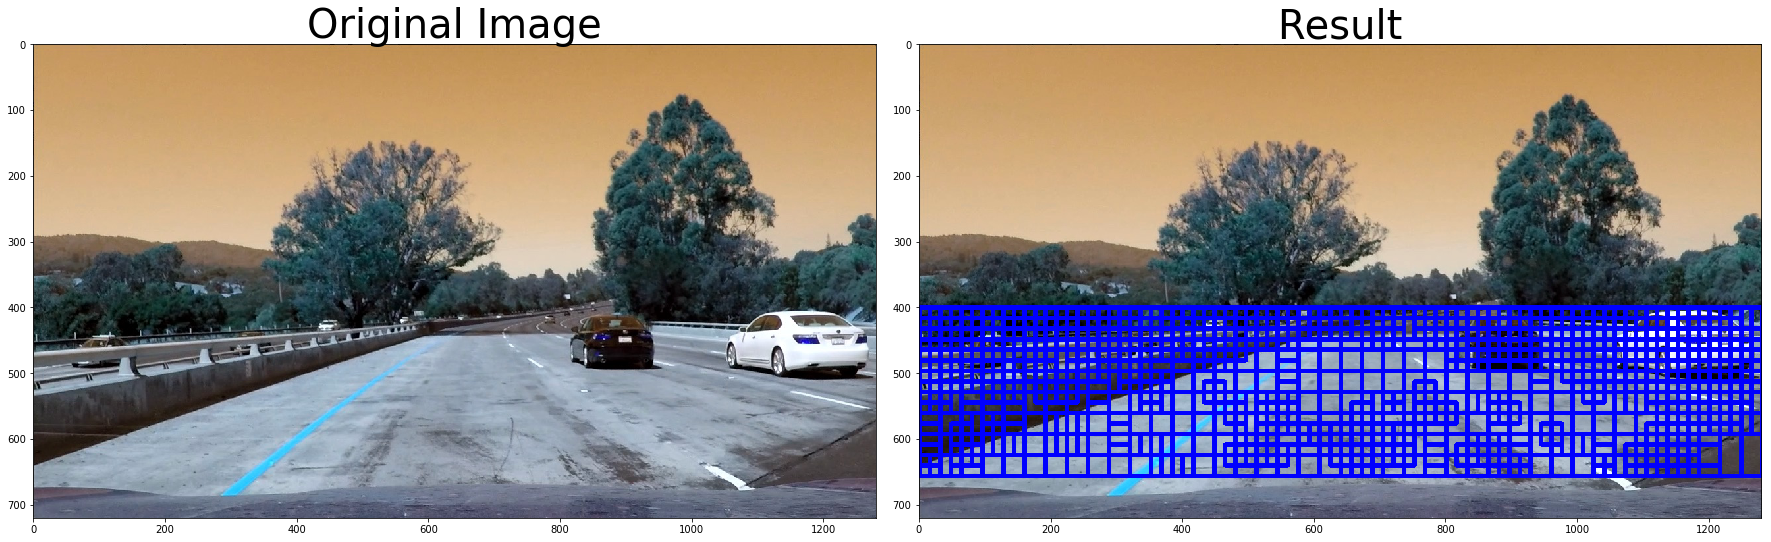

In [95]:
def single_img_features(image, cspace='YUV', spatial_size=(16, 16),
                        hist_bins=16, hist_range=(0, 256),
                        orient=8, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True, hog_channel=0):
    
    
    features= extract_features([image], cspace, spatial_size,
                        hist_bins, hist_range, orient, pix_per_cell, cell_per_block, 
                        vis, feature_vec, hog_channel)
    return features[0]

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, cspace='YUV', spatial_size=(16, 16),
                        hist_bins=16, hist_range=(0, 256),
                        orient=8, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True, hog_channel=0):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  

        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace, spatial_size,
                        hist_bins, hist_range, orient, pix_per_cell, cell_per_block, 
                        vis, feature_vec, hog_channel)
        #print(features.shape)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))

        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            #print("correct")
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def simple_pipeline(img):
    #global svc, X_scaler
    vis=False
    feature_vec=True

    x_start_stop=[None, None]
    y_start_stop=[400, 656]
    xy_window=(128, 128)
    xy_overlap=(0.5, 0.5)

    windows= pyramid_window(img, x_start_stop, y_start_stop, xy_window, xy_overlap)
    #print(windows)
    car_windows = search_windows(img, windows, svc, scaler, cspace, spatial_size,
                        hist_bins, hist_range, orient, 
                        pix_per_cell, cell_per_block, vis, feature_vec, hog_channel)

    #print(car_windows)
    window_img = draw_boxes(image, car_windows, color=(0, 0, 255), thick=6)  
    return window_img

def create_scaler():
    vis=False
    feature_vec=True

    x_start_stop=[None, None]
    y_start_stop=[400, 656]
    xy_window=(128, 128)
    xy_overlap=(0.5, 0.5)
    
    imgs=[]
    
    for i in range(1, 5):
        fname = './test_images/test{}.jpg'.format(i)
        image = cv2.imread(fname)
        
        windows= pyramid_window(img, x_start_stop, y_start_stop, xy_window, xy_overlap)
        #print(windows)
        for window in windows:
            #3) Extract the test window from original image
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  
            imgs.append(test_img)
            
    features = extract_features(imgs, cspace, spatial_size,
                        hist_bins, hist_range, orient, pix_per_cell, cell_per_block, 
                        vis, feature_vec, hog_channel)
    
    # Create an array stack of feature vectors
    X = np.asarray(features).astype(np.float64)

    # Fit a per-column scaler
    scaler = StandardScaler().fit(X)
    
    return scaler

scaler=create_scaler()

for i in range(1, 2):
    fname = './test_images/test{}.jpg'.format(i)
    image = cv2.imread(fname)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    #print(np.max(image))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)
    out_img=simple_pipeline(image)
    ax2.imshow(out_img)
    ax2.set_title('Result', fontsize=40)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

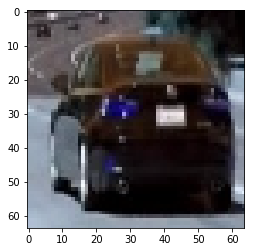

In [96]:
%matplotlib inline
fname = './test_images/test1.jpg'.format(i)
img = cv2.imread(fname)
img_car = cv2.resize(img[400:500, 800:950], (64, 64))
plt.imshow(img_car)

In [100]:
features=single_img_features(img_car, cspace, spatial_size,
                        hist_bins, hist_range, orient, pix_per_cell, cell_per_block, 
                        vis, feature_vec, hog_channel)

In [101]:
test_features = scaler.transform(np.array(features).astype(np.float64).reshape(1, -1))
print(test_features)
prediction = svc.predict(features)
print(prediction)

img_car=cars[0]

features=single_img_features(img_car, cspace, spatial_size,
                        hist_bins, hist_range, orient, pix_per_cell, cell_per_block, 
                        vis, feature_vec, hog_channel)
#test_features = X_scaler.transform(np.array(features).astype(np.float64).reshape(1, -1))
print(test_features)
prediction = svc.predict(features)
print(prediction)

[[-0.55217135 -0.41469131 -0.32227512 ..., -0.04074706  0.10823287
   0.14732142]]
[ 1.]
[[-0.55217135 -0.41469131 -0.32227512 ..., -0.04074706  0.10823287
   0.14732142]]
[ 1.]


/home/rm/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/rm/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
